In [14]:
# implementing "How to Develop a Deep CNN for MNIST Digit Classification"
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


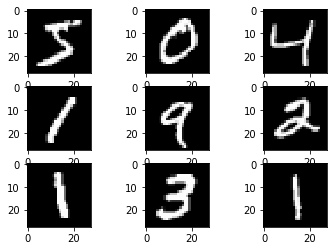

In [3]:
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [7]:
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [8]:
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

# Baseline Model

In [35]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluation

In [39]:
def evaluate_model(model, dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX):
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print(f'> {acc * 100.0:.3f}')
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [65]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['acc'], color='blue', label='train')
        plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()
    
def summarize_performance(scores):
    print(f'Accuracy: mean={mean(scores)*100:.3f} std={std(scores)*100:.3f}, n={len(scores)}')
    plt.boxplot(scores)
    plt.show()


# Run First Experiment

In [75]:
def run_test_harness(model):
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    scores, histories = evaluate_model(model, trainX, trainY)
    summarize_diagnostics(histories)
    summarize_performance(scores)

> 98.608
> 99.817
> 99.992
> 100.000
> 100.000


/Users/nyutal/.pyenv/versions/anaconda3-4.3.1/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nyutal/.pyenv/versions/anaconda3-4.3.1/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


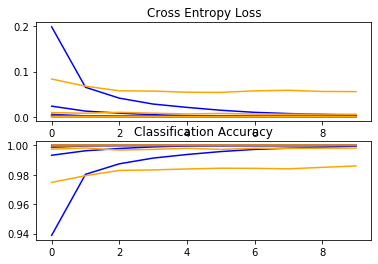

Accuracy: mean=99.683 std=0.542, n=5


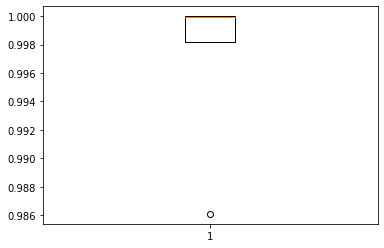

In [67]:
run_test_harness(baseline_model())

# Batch Normalization

In [70]:
def batch_normalized_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))

    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

> 98.650
> 99.908
> 99.992
> 99.992
> 100.000


/Users/nyutal/.pyenv/versions/anaconda3-4.3.1/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nyutal/.pyenv/versions/anaconda3-4.3.1/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


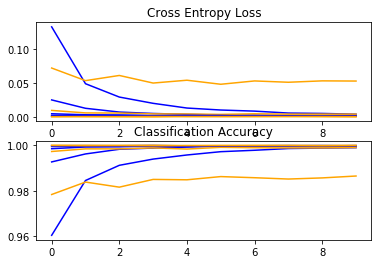

Accuracy: mean=99.708 std=0.530, n=5


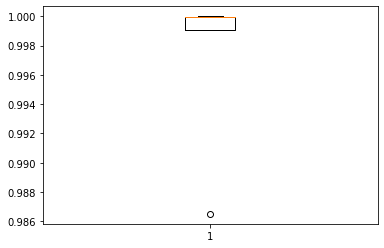

In [76]:
run_test_harness(batch_normalized_model())

# Deeper Model

In [5]:
def deeper_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
run_test_harness(deeper_model())

> 98.808
> 99.850
> 99.942


# Finalize Model

In [9]:
def produce_final_model(model_generator):
    trainX, trainY, testX, testY = load_dataset()
    trainX, testX = prep_pixels(trainX, testX)
    model = model_generator()
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    return model

In [10]:
model = produce_final_model(deeper_model)
model.save('final_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Evaluate Final Model

In [12]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)

model = load_model('final_model.h5')

_, acc = model.evaluate(testX, testY, verbose=0)
print(f'> {acc * 100.0:3f}')

> 99.170000


# Make Prediction

In [15]:
def load_image(filename):
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img = img / 255.0
    return img

In [16]:
img = load_image('sample_image.png')
model = load_model('final_model.h5')
digit = model.predict_classes(img)
print(digit[0])

/Users/nyutal/.pyenv/versions/anaconda3-4.3.1/envs/keras/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


7
